# Arizona 2020 General ERJ
**Additional Election Results Joined to VEST's Precinct Shapefile**

## Notes from VEST's Documentation File:

Election results from Arizona Secretary of State (https://azsos.gov/2020-election-information)
Precinct shapefile from Arizona Secretary of State via personal communication except Greenlee County is sourced from the county shapefile instead.

The following modifications were made to match the precinct boundaries for the 2020 general election.

Apache: Merge Puerco East/West

La Paz: Merge Alamo into Wenden

Maricopa: Merge South Mtn Park E, NE, S, SE, SW into South Mtn Park

- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20USSDKEL - Mark Kelly (Democratic Party)
- G20USSRMCS - Martha McSally (Republican Party)


## Notes on source precinct shapefile file from PDV notebook
VEST does not specify their shapefile source.

The VEST shapefile is the same as the 2018 one from Garrett Archer, except in 17 precincts, where 8 of those 17 precincts are the ones from Grenlee County that VEST subbed in with the county shapefile. [see validation script]

The RDH determined that we will not attempt to validate the VEST 2020 shapefile against the 2018 file from Garrett Archer, because we do not know if the 2018 file is an accurate representation of the geographies of precincts at the time of the 2020 election. We reached out to Garrett Archer on 6/14/2021 to see if he has the 2020 file and did not hear back as of 6/29/2021. 

In [1]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import geopandas as gp
import os
from erj_toolbox import *

'''Below pandas functions are essential to the readme displaying properly, 
Be sure to include!'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# VEST Precinct Shapefile

## Load VEST's Final File - processed election results

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/az_2020/az_2020.shp")
vest_shp.shape

(1489, 9)

In [3]:
vest_shp.head(1)

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


In [4]:
vest_shp.PRECINCTNA.nunique()

1464

In [5]:
vest_shp.PCTNUM.nunique()

1489

<AxesSubplot:>

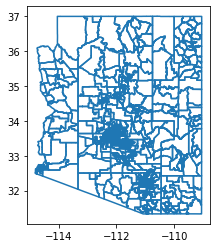

In [6]:
vest_shp.boundary.plot()

# SOS Election Results

NOTE FROM PDV NOTEBOOK: Running the cell below initially gave the following error: `IOPub data rate exceeded. The Jupyter server will temporarily stop sending output to the client in order to avoid crashing it.`

To fix this, run the jupyter notebook from terminal with: 
`jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10` or `jupyter-lab --NotebookApp.iopub_data_rate_limit=1e10
`

In [7]:
## Election Results XML to df
def read_az_sos_xml(xml_file_path):
    '''xml_file_path refers to the path to the election results
    The roots and attributes called in this function are based on those used by the Arizona SOS in 2020. 
    The general structure can be used for any xml file, but attribute names must be changed.
    '''
    xmlparse = Xet.parse(xml_file_path)
    root = xmlparse.getroot()
    data = []
    lower = root.findall(".//contest")
    for i in lower:
        contest = i.attrib.get('contestLongName')
        lower1 = i.findall('.//choice')
        for j in lower1:
            choice = j.attrib.get('choiceName')
            party = j.attrib.get('party')
            total_votes = j.attrib.get('totalVotes')
            is_write_in = j.attrib.get('isWriteIn')
            lower2 = j.findall('.//jurisdiction')
            for k in lower2:
                jurisdiction_key = k.attrib.get('key')
                jurisdiction_name = k.attrib.get('name')
                jurisdiction_total = k.attrib.get('votes')
                lower3 = k.findall('.//precinct')
                for l in lower3:
                    precinct_key = l.attrib.get('key')
                    precinct_name = l.attrib.get('name').upper()
                    precinct_votes = l.attrib.get('votes')
                    data.append([contest, choice, party, total_votes, is_write_in, jurisdiction_key, jurisdiction_name, jurisdiction_total, 
                                     precinct_key, precinct_name, precinct_votes])
    dfcols = ['contest','choice','party','total_votes','is_write_in','jurisdiction_key','jurisdiction_name','jurisdiction_total',
              'precinct_key','precinct_name','precinct_votes']
    df = pd.DataFrame(data,columns=dfcols)
    #Convert votes to int so numbers can be compared as numbers
    df["precinct_votes"]=df["precinct_votes"].astype(int)
    return df

## Load in all general election results from SOS as df

In [8]:
#Load in general election results
gen_xml_path = './raw-from-source/SOS/Results.Detail_2020General.xml'
df = read_az_sos_xml(gen_xml_path)

#Cut out local judge elections - not statewide
df = df[~df['contest'].map(lambda x: ('Judge of the Court of Appeals  Division' in x)|('Judge of the Court of Appeals' in x))]
df = df[df['is_write_in'] != 'true']

## Add district numbers to df, create district-precinct ids, and check for splits
Note this district splitting was not an issue in the initial round of PDV because sldl, sldu and usreps were not included
</br>Be careful to make sure votes properly distributed/split!

In [9]:
#Add district # as column to identify US House, State House/Senate districts where appropriate - create variables to use in fxn
#state senator
df['sldu_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)), 'sldu_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)),'contest'].str.slice(start = -2).str.replace(' ', '0').str.zfill(2)
#state representative
df['sldl_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)), 'sldl_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)),'contest'].str.slice(start = -2).str.replace(' ', '0').str.zfill(2)
#US House
df['usrep_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'usrep_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'contest'].str.slice(start = -2).str.replace(' ', '0').str.zfill(2)

df['prec_id_sldl_sldu_usrep'] = mk_precinct_district_id(df, 'precinct_key', 'sldl_dist', 'sldu_dist', 'usrep_dist')
prec_split_check(df, 'precinct_name', vest_shp, 'PCTNUM', 'sldl_dist', 'sldu_dist', 'usrep_dist', 'prec_id_sldl_sldu_usrep')

# vest unique precinct ids:  1489 
 # sos unique precinct ids:  1489 
 # sos ids with districts attached:  1489
Counts match - no splits occurred!


## Create column headers based on contest

In [10]:
#Party to character dictionaries/setting variables
az_party_dict = {'DEM': 'D','ACN': 'A','Green': 'G', 'LBT': 'L', 'REP': 'R','IND': 'I','UPA': 'U','CSM': 'C',
                 'None': 'O', #changed default
                 'Party for Socialism and Liberation': 'S', #changed default
                 'IRP': 'P' #changed default
                 }
az_party_dict_3char = {'DEM': 'DEM','ACN': 'ACN','Green': 'GRE','LBT': 'LBT','REP': 'REP','IND': 'IND','UPA': 'UPA','CSM': 'CSM',
                       'None': 'OTH', #changed default
                         'Party for Socialism and Liberation': 'SAL', #changed default
                         'IRP': 'IRP' #changed default
                      }
contest_col='contest'
election_type = 'G'
election_year = '20'
df['party_1char'] = df['party'].map(az_party_dict)
df['party_3char'] = df['party'].map(az_party_dict_3char)
df['choice_3char'] = df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)
df['prop_number'] = df['contest'].str.slice(start = -3)
df['prop_choice'] = df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 1)
#df['sldl_dist'] = df['sldl_dist'].map(lambda x: "".join(filter(str.isalnum, x)))
#df['sldu_dist'] = df['sldu_dist'].map(lambda x: "".join(filter(str.isalnum, x)))
#at_large = True
df['usrep_dist'] = df['usrep_dist'].map(lambda x: "".join(filter(str.isalnum, x)))

df['field_id'] = create_field_id(df, contest_col, election_type, election_year, 
                                party_1char='party_1char', party_3char='party_3char', choice_3char='choice_3char',
                                 prop_number='prop_number', prop_choice='prop_choice')    

**create separate df to process ssc info** - variables need to be different for contest and choice need to be different from the rest

In [11]:
df_ssc = df[df['contest'].map(lambda x:('Supreme Court' in x))]

df_ssc['choice_3char'] = df_ssc['contest'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(start=5, stop=8)
df_ssc['ssc_yes_or_no'] = df_ssc['choice'].str.slice(stop = 1)
df_ssc['field_id'] = create_field_id(df_ssc, contest_col, election_type, election_year, choice_3char = 'choice_3char', 
                                     ssc_yes_or_no = 'ssc_yes_or_no', sldl_zfill=2, sldu_zfill=2)

<ipython-input-11-40214cbbaddf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssc['choice_3char'] = df_ssc['contest'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(start=5, stop=8)
<ipython-input-11-40214cbbaddf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssc['ssc_yes_or_no'] = df_ssc['choice'].str.slice(stop = 1)
/Users/lilyfalk/election_joins/testing/pdv-vest-az-2020/erj_toolbox.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

**cut out the df_ssc data from df that will be handled separately**

In [12]:
df = df[~df['contest'].map(lambda x:('Supreme Court' in x))]

## Pivot general election results

### Pivot df

In [13]:
prec_row_df = pd.pivot_table(df, index = ['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep'], 
                             columns = ['field_id'], 
                             values = ['precinct_votes'], 
                             aggfunc = np.sum)
prec_row_df.head(2)

precinct_votes  \
field_id                                                              G20COCDMUN   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                      
Apache            02 ALPINE           [9179-07][9179-07][9179-01]           91.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]         1213.0   

                                                                              \
field_id                                                          G20COCDSTA   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]       76.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]     1329.0   

                                                                              \
field_id                                                          G20COCDTOV   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]       86.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]     1322.0   

                                                                              \
field_id                                                          G20COCRMAR   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]      242.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]      174.0   

                                                                              \
field_id                                                          G20COCROCO   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]      257.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]      210.0   

                                                                              \
field_id                                                          G20COCRSLO   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]      233.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]      196.0   

                                                                              \
field_id                                                          G20PREDBID   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]       94.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]     1982.0   

                                                                              \
field_id                                                          G20PRELJOR   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]        5.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]       30.0   

                                                                              \
field_id                                                          G20PRERTRU   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]      283.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]      273.0   

                                                                              \
field_id                                                          G20PRO207N   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]      207.0   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]     1154.0   

                                    

In [14]:
#rename columns
prec_row_df.columns = prec_row_df.columns.to_series().str.join(' ')
prec_row_df = prec_row_df.fillna(0)
prec_row_df.reset_index(inplace=True)
prec_row_df.columns = prec_row_df.columns.map(lambda x : x if 'precinct_votes ' not in x else  x[len('precinct_votes '):])
prec_row_df.head()

,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PREDBID,G20PRELJOR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDKEL,G20USSRMCS,GCON01DOHA,GCON01RSHE,GCON02DKIR,GCON02RMAR,GCON03DGRI,GCON03RWOO,GCON04DDIS,GCON04RGOS,GCON05DGRE,GCON05RBIG,GCON06DTIP,GCON06RSCH,GCON07DGAL,GCON07RBAR,GCON08DMUS,GCON08RLES,GCON09DSTA,GCON09RGIL,GSL01DSTA,GSL01RBUR,GSL01RNGU,GSL02DDAL,GSL02DHER,GSL02RMCE,GSL03DCAN,GSL03DHER,GSL04DFER,GSL04DPET,GSL04RJOH,GSL05RBIA,GSL05RCOB,GSL06DEVA,GSL06IBAB,GSL06RBAR,GSL06RBLA,GSL07DTEL,GSL07DTSO,GSL07RPAR,GSL07RPEE,GSL08DGIR,GSL08RCOO,GSL08RPRA,GSL09DFRI,GSL09DPOW,GSL09RLYO,GSL10DDEG,GSL10DSTA,GSL10RGUM,GSL10RHIC,GSL11DPER,GSL11RFIN,GSL11RROB,GSL12RGRA,GSL12RHOF,GSL13DSAN,GSL13RDUN,GSL13ROSB,GSL14DBEA,GSL14DMAE,GSL14RGRI,GSL14RNUT,GSL15DDYB,GSL15RKAI,GSL15RWIL,GSL16DHUN,GSL16RFIL,GSL16RPAR,GSL17DPAW,GSL17RHAR,GSL17RWEN,GSL18DEPS,GSL18DJER,GSL18RHAW,GSL18RROB,GSL19DESP,GSL19DSIE,GSL20DSCH,GSL20RBOL,GSL20RKER,GSL21DKNE,GSL21RPAY,GSL21RPIN,GSL22DGAR,GSL22DHON,GSL22RCAR,GSL22RTOM,GSL23DKUR,GSL23RCHA,GSL23RKAV,GSL24DLON,GSL24DSHA,GSL24RALG,GSL24RCUS,GSL25DHUG,GSL25RBOW,GSL25RUDA,GSL26DHER,GSL26DSAL,GSL26RLOU,GSL26RSIF,GSL27DBOL,GSL27DROD,GSL27RPEÑ,GSL28DBUT,GSL28DLIE,GSL28RBOW,GSL28RJAC,GSL29DAND,GSL29DCHA,GSL29RBRA,GSL29RFOK,GSL30DMEZ,GSL30DTER,GSU01DCAR,GSU01RFAN,GSU02DGAB,GSU02RWOR,GSU03DGON,GSU04DOTO,GSU04RANG,GSU05RBOR,GSU06DFRE,GSU06RROG,GSU07DPES,GSU08DMCG,GSU08RSHO,GSU09DSTE,GSU10DENG,GSU10RWAD,GSU11DMEN,GSU11RLEA,GSU12DROB,GSU12RPET,GSU13RKER,GSU14DKAR,GSU14RGOW,GSU15RBAR,GSU16RTOW,GSU17DKUR,GSU17RMES,GSU18DBOW,GSU18RSHA,GSU19DCHA,GSU20DERV,GSU20RBOY,GSU21RGRA,GSU22DTYR,GSU22RLIV,GSU23DBLA,GSU23RUGE,GSU24DALS,GSU24RMIC,GSU25DWEI,GSU25RPAC,GSU26DMEN,GSU26RCHI,GSU27DRIO,GSU27RSHR,GSU28DMAR,GSU28RBRO,GSU29DQUE,GSU29RWIL,GSU30DNAV
0,Apache,02 ALPINE,[9179-07][9179-07][9179-01],91.0,76.0,86.0,242.0,257.0,233.0,94.0,5.0,283.0,207.0,168.0,260.0,116.0,98.0,284.0,105.0,271.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apache,03 CANYON DE CHELLY,[9180-07][9180-07][9180-01],1213.0,1329.0,1322.0,174.0,210.0,196.0,1982.0,30.0,273.0,1154.0,1010.0,726.0,1431.0,1995.0,290.0,1964.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Apache,05 CHINLE,[9181-07][9181-07][9181-01],639.0,611.0,720.0,100.0,125.0,126.0,989.0,20.0,148.0,476.0,634.0,302.0,807.0,994.0,157.0,964.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,876.0,92.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Pivot df_ssc

In [15]:
prec_row_df_ssc = pd.pivot_table(df_ssc, index = ['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep'], 
                             columns = ['field_id'], 
                             values = ['precinct_votes'], 
                             aggfunc = np.sum)
prec_row_df_ssc.head(2)

precinct_votes  \
field_id                                                              G20SSCNBRU   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                      
Apache            02 ALPINE           [9179-07][9179-07][9179-01]             71   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]            564   

                                                                              \
field_id                                                          G20SSCNGOU   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]         73   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]        558   

                                                                              \
field_id                                                          G20SSCNLOP   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]         81   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]        558   

                                                                              \
field_id                                                          G20SSCYBRU   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]        237   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]       1608   

                                                                              \
field_id                                                          G20SSCYGOU   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                  
Apache            02 ALPINE           [9179-07][9179-07][9179-01]        236   
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]       1613   

                                                                              
field_id                                                          G20SSCYLOP  
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                 
Apache            02 ALPINE           [9179-07][9179-07][9179-01]        228  
                  03 CANYON DE CHELLY [9180-07][9180-07][9180-01]       1610

In [16]:
#rename columns
prec_row_df_ssc.columns = prec_row_df_ssc.columns.to_series().str.join(' ')
prec_row_df_ssc = prec_row_df_ssc.fillna(0)
prec_row_df_ssc.reset_index(inplace=True)
prec_row_df_ssc.columns = prec_row_df_ssc.columns.map(lambda x : x if 'precinct_votes ' not in x else  x[len('precinct_votes '):])
prec_row_df_ssc.head()

,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20SSCNBRU,G20SSCNGOU,G20SSCNLOP,G20SSCYBRU,G20SSCYGOU,G20SSCYLOP
0,Apache,02 ALPINE,[9179-07][9179-07][9179-01],71,73,81,237,236,228
1,Apache,03 CANYON DE CHELLY,[9180-07][9180-07][9180-01],564,558,558,1608,1613,1610
2,Apache,05 CHINLE,[9181-07][9181-07][9181-01],326,323,302,731,734,753
3,Apache,09 CONCHO,[9182-07][9182-07][9182-01],335,399,374,1064,984,1017
4,Apache,10 CORNFIELDS,[9183-07][9183-07][9183-01],113,106,101,336,345,348


### Join df, df_ssc back together

In [17]:
prec_row_df = prec_row_df.merge(prec_row_df_ssc, how = 'outer', on = ['jurisdiction_name','precinct_name', 'prec_id_sldl_sldu_usrep'], suffixes=('_x', '_y')
                            , indicator = True)

### Add district columns back in

In [18]:
#Assign district numbers to separate column
prec_row_df['SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 6, stop = 8)
prec_row_df.loc[prec_row_df['prec_id_sldl_sldu_usrep'].str.startswith('[10'), 'SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 7, stop = 9)
prec_row_df['SL_DIST'] = prec_row_df['SL_DIST'].str.replace(' ', '0').str.zfill(2)
prec_row_df['SLDL_DIST'] = prec_row_df['SL_DIST']
prec_row_df['SLDU_DIST'] = prec_row_df['SL_DIST']
prec_row_df['CON_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = -3, stop = -1).str.replace(' ', '0').str.zfill(2)

In [19]:
# Precinct key and values map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.precinct_name.value_counts().values).all()

True

In [20]:
# Precinct key and prec_district_ids map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.prec_id_sldl_sldu_usrep.value_counts().values).all()

True

# Prepare to validate election results

## Add county fips to df and to VEST file

In [21]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Arizona"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
az_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

prec_row_df['COUNTYFP'] = prec_row_df['jurisdiction_name'].apply(lambda x: az_fips_dict.get(x))

#FOR VEST FILE
#Map VEST county name abbreviations to county names
cde_county_dict = {'AP':'Apache', 'CH':'Cochise', 'CN':'Coconino', 'GI':'Gila', 'GM':'Graham', 'LP':'La Paz', 'MO':'Mohave', 'PN':'Pinal', 'SC':'Santa Cruz', 'YA':'Yavapai', 'NA':'Navajo',
       'YU':'Yuma', 'MC':'Maricopa', 'PM':'Pima', 'GN':'Greenlee'}

#Use above mapping to create county fips column
vest_shp['county_name'] = vest_shp['CDE_COUNTY'].apply(lambda x: cde_county_dict.get(x))
vest_shp['COUNTYFP'] = vest_shp['county_name'].apply(lambda x: az_fips_dict.get(x)).str.zfill(3)

## Merge SOS Election Results and VEST's

In [22]:
vest_shp.shape

(1489, 11)

In [23]:
prec_row_df.shape

(1489, 193)

In [24]:
prec_row_df['precinct_name'].nunique()

1489

In [25]:
prec_row_df.columns

Index(['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep',
       'G20COCDMUN', 'G20COCDSTA', 'G20COCDTOV', 'G20COCRMAR', 'G20COCROCO',
       'G20COCRSLO', 'G20PREDBID',
       ...
       'G20SSCNLOP', 'G20SSCYBRU', 'G20SSCYGOU', 'G20SSCYLOP', '_merge',
       'SL_DIST', 'SLDL_DIST', 'SLDU_DIST', 'CON_DIST', 'COUNTYFP'],
      dtype='object', length=193)

**During validation for PDV, did join attempt 1, then wrote to shp, then matched below by hand**
</br>Notes: 
- Gila County (007): compare VEST P/S EAST and P/S WEST with SOS
- Graham County (009): need to use the PCTNUM to figure out the 3 SAFFORD precincts
</br>Lined up all of the precincts by hand and loaded back in as dictionary file. 

## Read in csv made during PDV to match counties and precincts for join

In [26]:
precinct_dictionary_csv = pd.read_csv('election_results_dictionary.csv', dtype = {'COUNTYFP_vest':'object','COUNTYFP_sos':'object'})

vest_shp_merged = vest_shp.merge(precinct_dictionary_csv, how = 'outer', left_on = ['PCTNUM'], 
                                                right_on = ['PCTNUM_vest'], indicator = True)
vest_shp_merged.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
_merge,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [27]:
vest_shp_merged.shape

(1489, 19)

## Join vest df to processed SOS df

In [28]:
#df vest merged with updated pct names to join to sos
vest_shp_merged.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry', 'county_name',
       'COUNTYFP', 'COUNTYFP_vest', 'PCTNUM_vest', 'PRECINCTNA_vest',
       'G20PREDBID_vest', 'COUNTYFP_sos', 'precinct_name_sos',
       'G20PREDBID_sos', '_merge'],
      dtype='object')

In [29]:
vest_shp_merged['precinct_name_sos'].nunique()

1489

In [30]:
vest_shp_merged['PRECINCTNA'].nunique()

1464

**Joining using sos precinct name since it is actually unique**

In [31]:
#Drop to enable join later on
vest_shp_merged.drop(columns = ['_merge'], inplace = True)
prec_row_df.drop(columns = ['_merge'], inplace = True)
#merge
vest_shp_merged['precinct_name_sos']=vest_shp_merged['precinct_name_sos'].str.upper()
df_joined_to_vest = vest_shp_merged.merge(prec_row_df, how = 'outer'
                            , left_on = ['COUNTYFP','precinct_name_sos'], right_on = ['COUNTYFP','precinct_name'], suffixes=('_x', ''), indicator = True)

In [32]:
df_joined_to_vest.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PREDBID,G20PRELJOR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDKEL,G20USSRMCS,GCON01DOHA,GCON01RSHE,GCON02DKIR,GCON02RMAR,GCON03DGRI,GCON03RWOO,GCON04DDIS,GCON04RGOS,GCON05DGRE,GCON05RBIG,GCON06DTIP,GCON06RSCH,GCON07DGAL,GCON07RBAR,GCON08DMUS,GCON08RLES,GCON09DSTA,GCON09RGIL,GSL01DSTA,GSL01RBUR,GSL01RNGU,GSL02DDAL,GSL02DHER,GSL02RMCE,GSL03DCAN,GSL03DHER,GSL04DFER,GSL04DPET,GSL04RJOH,GSL05RBIA,GSL05RCOB,GSL06DEVA,GSL06IBAB,GSL06RBAR,GSL06RBLA,GSL07DTEL,GSL07DTSO,GSL07RPAR,GSL07RPEE,GSL08DGIR,GSL08RCOO,GSL08RPRA,GSL09DFRI,GSL09DPOW,GSL09RLYO,GSL10DDEG,GSL10DSTA,GSL10RGUM,GSL10RHIC,GSL11DPER,GSL11RFIN,GSL11RROB,GSL12RGRA,GSL12RHOF,GSL13DSAN,GSL13RDUN,GSL13ROSB,GSL14DBEA,GSL14DMAE,GSL14RGRI,GSL14RNUT,GSL15DDYB,GSL15RKAI,GSL15RWIL,GSL16DHUN,GSL16RFIL,GSL16RPAR,GSL17DPAW,GSL17RHAR,GSL17RWEN,GSL18DEPS,GSL18DJER,GSL18RHAW,GSL18RROB,GSL19DESP,GSL19DSIE,GSL20DSCH,GSL20RBOL,GSL20RKER,GSL21DKNE,GSL21RPAY,GSL21RPIN,GSL22DGAR,GSL22DHON,GSL22RCAR,GSL22RTOM,GSL23DKUR,GSL23RCHA,GSL23RKAV,GSL24DLON,GSL24DSHA,GSL24RALG,GSL24RCUS,GSL25DHUG,GSL25RBOW,GSL25RUDA,GSL26DHER,GSL26DSAL,GSL26RLOU,GSL26RSIF,GSL27DBOL,GSL27DROD,GSL27RPEÑ,GSL28DBUT,GSL28DLIE,GSL28RBOW,GSL28RJAC,GSL29DAND,GSL29DCHA,GSL29RBRA,GSL29RFOK,GSL30DMEZ,GSL30DTER,GSU01DCAR,GSU01RFAN,GSU02DGAB,GSU02RWOR,GSU03DGON,GSU04DOTO,GSU04RANG,GSU05RBOR,GSU06DFRE,GSU06RROG,GSU07DPES,GSU08DMCG,GSU08RSHO,GSU09DSTE,GSU10DENG,GSU10RWAD,GSU11DMEN,GSU11RLEA,GSU12DROB,GSU12RPET,GSU13RKER,GSU14DKAR,GSU14RGOW,GSU15RBAR,GSU16RTOW,GSU17DKUR,GSU17RMES,GSU18DBOW,GSU18RSHA,GSU19DCHA,GSU20DERV,GSU20RBOY,GSU21RGRA,GSU22DTYR,GSU22RLIV,GSU23DBLA,GSU23RUGE,GSU24DALS,GSU24RMIC,GSU25DWEI,GSU25RPAC,GSU26DMEN,GSU26RCHI,GSU27DRIO,GSU27RSHR,GSU28DMAR,GSU28RBRO,GSU29DQUE,GSU29RWIL,GSU30DNAV,G20SSCNBRU,G20SSCNGOU,G20SSCNLOP,G20SSCYBRU,G20SSCYGOU,G20SSCYLOP,SL_DIST,SLDL_DIST,SLDU_DIST,CON_DIST
_merge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1

In [33]:
df_joined_to_vest.head(2)

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PREDBID,G20PRELJOR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDKEL,G20USSRMCS,GCON01DOHA,GCON01RSHE,GCON02DKIR,GCON02RMAR,GCON03DGRI,GCON03RWOO,GCON04DDIS,GCON04RGOS,GCON05DGRE,GCON05RBIG,GCON06DTIP,GCON06RSCH,GCON07DGAL,GCON07RBAR,GCON08DMUS,GCON08RLES,GCON09DSTA,GCON09RGIL,GSL01DSTA,GSL01RBUR,GSL01RNGU,GSL02DDAL,GSL02DHER,GSL02RMCE,GSL03DCAN,GSL03DHER,GSL04DFER,GSL04DPET,GSL04RJOH,GSL05RBIA,GSL05RCOB,GSL06DEVA,GSL06IBAB,GSL06RBAR,GSL06RBLA,GSL07DTEL,GSL07DTSO,GSL07RPAR,GSL07RPEE,GSL08DGIR,GSL08RCOO,GSL08RPRA,GSL09DFRI,GSL09DPOW,GSL09RLYO,GSL10DDEG,GSL10DSTA,GSL10RGUM,GSL10RHIC,GSL11DPER,GSL11RFIN,GSL11RROB,GSL12RGRA,GSL12RHOF,GSL13DSAN,GSL13RDUN,GSL13ROSB,GSL14DBEA,GSL14DMAE,GSL14RGRI,GSL14RNUT,GSL15DDYB,GSL15RKAI,GSL15RWIL,GSL16DHUN,GSL16RFIL,GSL16RPAR,GSL17DPAW,GSL17RHAR,GSL17RWEN,GSL18DEPS,GSL18DJER,GSL18RHAW,GSL18RROB,GSL19DESP,GSL19DSIE,GSL20DSCH,GSL20RBOL,GSL20RKER,GSL21DKNE,GSL21RPAY,GSL21RPIN,GSL22DGAR,GSL22DHON,GSL22RCAR,GSL22RTOM,GSL23DKUR,GSL23RCHA,GSL23RKAV,GSL24DLON,GSL24DSHA,GSL24RALG,GSL24RCUS,GSL25DHUG,GSL25RBOW,GSL25RUDA,GSL26DHER,GSL26DSAL,GSL26RLOU,GSL26RSIF,GSL27DBOL,GSL27DROD,GSL27RPEÑ,GSL28DBUT,GSL28DLIE,GSL28RBOW,GSL28RJAC,GSL29DAND,GSL29DCHA,GSL29RBRA,GSL29RFOK,GSL30DMEZ,GSL30DTER,GSU01DCAR,GSU01RFAN,GSU02DGAB,GSU02RWOR,GSU03DGON,GSU04DOTO,GSU04RANG,GSU05RBOR,GSU06DFRE,GSU06RROG,GSU07DPES,GSU08DMCG,GSU08RSHO,GSU09DSTE,GSU10DENG,GSU10RWAD,GSU11DMEN,GSU11RLEA,GSU12DROB,GSU12RPET,GSU13RKER,GSU14DKAR,GSU14RGOW,GSU15RBAR,GSU16RTOW,GSU17DKUR,GSU17RMES,GSU18DBOW,GSU18RSHA,GSU19DCHA,GSU20DERV,GSU20RBOY,GSU21RGRA,GSU22DTYR,GSU22RLIV,GSU23DBLA,GSU23RUGE,GSU24DALS,GSU24RMIC,GSU25DWEI,GSU25RPAC,GSU26DMEN,GSU26RCHI,GSU27DRIO,GSU27RSHR,GSU28DMAR,GSU28RBRO,GSU29DQUE,GSU29RWIL,GSU30DNAV,G20SSCNBRU,G20SSCNGOU,G20SSCNLOP,G20SSCYBRU,G20SSCYGOU,G20SSCYLOP,SL_DIST,SLDL_DIST,SLDU_DIST,CON_DIST,_merge
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,001,001,AP0002,ALPINE,94,001,02 ALPINE,94,Apache,02 ALPINE,[9179-07][9179-07][9179-01],91.0,76.0,86.0,242.0,257.0,233.0,94.0,5.0,283.0,207.0,168.0,260.0,116.0,98.0,284.0,105.0,271.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71,73,81,237,236,228,07,07,07,01,both
1,AP,AP0003,CANYON DE CHELLY,1982,273,30,1995,290,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,001,001,AP0003,CANYON DE CHELLY,1982,001,03 CANYON DE CHELLY,1982,Apache,03 CANYON DE CHELLY,[9180-07][9180-07][9180-01],1213.0,1329.0,1322.0,174.0,210.0,196.0,1982.0,30.0,273.0,1154.0,1010.0,726.0,1431.0,1995.0,290.0,1964.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [34]:
df_joined_to_vest.shape

(1489, 210)

# Election Results Validation
Check to make sure election results still match VESTs after RDH additional election joins

## Race Totals

In [35]:
column_list = ['G20PREDBID', 'G20PRERTRU','G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS']
column_total_check(column_list, prec_row_df, vest_shp)

G20PREDBID: EQUAL  - total:  1672143.0
G20PRERTRU: EQUAL  - total:  1661686.0
G20PRELJOR: EQUAL  - total:  51465.0
G20USSDKEL: EQUAL  - total:  1716467.0
G20USSRMCS: EQUAL  - total:  1637661.0


## County-by-County Totals

In [36]:
county_total_check(column_list, prec_row_df, vest_shp)

Counties with differences printed below:

All other races in all counties are equal


## Precinct-by-Precinct Votes

In [37]:
validater_precinct_row(df_joined_to_vest, column_list, "precinct_name", suffix_2 = '')


There are  1489  total rows
0  of these rows have election result differences
1489  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10


# Create final gdf 
- Format columns to be in intuitive order based on race

We assured ourselves that our formatted results matched VEST's, VEST's file is used as the geographic data source since a raw shapefile was not available.

In [38]:
pre_list = select_cols(prec_row_df, 'G20PRE')
uss_list = select_cols(prec_row_df, 'G20USS')
con_list = select_cols(prec_row_df, 'GCON')
ssc_list = select_cols(prec_row_df, 'G20SSC')
coc_list = select_cols(prec_row_df, 'G20COC')
pro_list = select_cols(prec_row_df, 'G20PRO')
slu_list = select_cols(prec_row_df, 'GSU')
sll_list = select_cols(prec_row_df, 'GSL')
election_columns = pre_list + uss_list + con_list + ssc_list + coc_list + pro_list + slu_list + sll_list

df_joined_to_vest['UNIQUE_ID'] = df_joined_to_vest['precinct_name']
df_joined_to_vest['COUNTY_NAM'] = df_joined_to_vest['county_name']
location_desc_cols = ['UNIQUE_ID', 'COUNTYFP', 'PCTNUM', 'PRECINCTNA', 'CDE_COUNTY', 'COUNTY_NAM', 'CON_DIST', 'SLDL_DIST', 'SLDU_DIST']
geo_col = ['geometry']

final_column_order = format_erj_cols(location_desc_cols, election_columns, geo_col)
gdf = df_joined_to_vest[final_column_order]

In [39]:
gdf.head()

,UNIQUE_ID,COUNTYFP,PCTNUM,PRECINCTNA,CDE_COUNTY,COUNTY_NAM,CON_DIST,SLDL_DIST,SLDU_DIST,G20PREDBID,G20PRELJOR,G20PRERTRU,G20USSDKEL,G20USSRMCS,GCON01DOHA,GCON01RSHE,GCON02DKIR,GCON02RMAR,GCON03DGRI,GCON03RWOO,GCON04DDIS,GCON04RGOS,GCON05DGRE,GCON05RBIG,GCON06DTIP,GCON06RSCH,GCON07DGAL,GCON07RBAR,GCON08DMUS,GCON08RLES,GCON09DSTA,GCON09RGIL,G20SSCNBRU,G20SSCNGOU,G20SSCNLOP,G20SSCYBRU,G20SSCYGOU,G20SSCYLOP,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,GSU01DCAR,GSU01RFAN,GSU02DGAB,GSU02RWOR,GSU03DGON,GSU04DOTO,GSU04RANG,GSU05RBOR,GSU06DFRE,GSU06RROG,GSU07DPES,GSU08DMCG,GSU08RSHO,GSU09DSTE,GSU10DENG,GSU10RWAD,GSU11DMEN,GSU11RLEA,GSU12DROB,GSU12RPET,GSU13RKER,GSU14DKAR,GSU14RGOW,GSU15RBAR,GSU16RTOW,GSU17DKUR,GSU17RMES,GSU18DBOW,GSU18RSHA,GSU19DCHA,GSU20DERV,GSU20RBOY,GSU21RGRA,GSU22DTYR,GSU22RLIV,GSU23DBLA,GSU23RUGE,GSU24DALS,GSU24RMIC,GSU25DWEI,GSU25RPAC,GSU26DMEN,GSU26RCHI,GSU27DRIO,GSU27RSHR,GSU28DMAR,GSU28RBRO,GSU29DQUE,GSU29RWIL,GSU30DNAV,GSL01DSTA,GSL01RBUR,GSL01RNGU,GSL02DDAL,GSL02DHER,GSL02RMCE,GSL03DCAN,GSL03DHER,GSL04DFER,GSL04DPET,GSL04RJOH,GSL05RBIA,GSL05RCOB,GSL06DEVA,GSL06IBAB,GSL06RBAR,GSL06RBLA,GSL07DTEL,GSL07DTSO,GSL07RPAR,GSL07RPEE,GSL08DGIR,GSL08RCOO,GSL08RPRA,GSL09DFRI,GSL09DPOW,GSL09RLYO,GSL10DDEG,GSL10DSTA,GSL10RGUM,GSL10RHIC,GSL11DPER,GSL11RFIN,GSL11RROB,GSL12RGRA,GSL12RHOF,GSL13DSAN,GSL13RDUN,GSL13ROSB,GSL14DBEA,GSL14DMAE,GSL14RGRI,GSL14RNUT,GSL15DDYB,GSL15RKAI,GSL15RWIL,GSL16DHUN,GSL16RFIL,GSL16RPAR,GSL17DPAW,GSL17RHAR,GSL17RWEN,GSL18DEPS,GSL18DJER,GSL18RHAW,GSL18RROB,GSL19DESP,GSL19DSIE,GSL20DSCH,GSL20RBOL,GSL20RKER,GSL21DKNE,GSL21RPAY,GSL21RPIN,GSL22DGAR,GSL22DHON,GSL22RCAR,GSL22RTOM,GSL23DKUR,GSL23RCHA,GSL23RKAV,GSL24DLON,GSL24DSHA,GSL24RALG,GSL24RCUS,GSL25DHUG,GSL25RBOW,GSL25RUDA,GSL26DHER,GSL26DSAL,GSL26RLOU,GSL26RSIF,GSL27DBOL,GSL27DROD,GSL27RPEÑ,GSL28DBUT,GSL28DLIE,GSL28RBOW,GSL28RJAC,GSL29DAND,GSL29DCHA,GSL29RBRA,GSL29RFOK,GSL30DMEZ,GSL30DTER,geometry
0,02 ALPINE,001,AP0002,ALPINE,AP,Apache,01,07,07,94.0,5.0,283.0,98.0,284.0,105.0,271.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71,73,81,237,236,228,91.0,76.0,86.0,242.0,257.0,233.0,207.0,168.0,260.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."
1,03 CANYON DE CHELLY,001,AP0003,CANYON DE CHELLY,AP,Apache,01,07,07,1982.0,30.0,273.0,1995.0,290.0,1964.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,564,558,558,1608,1613,1610,1213.0,1329.0,1322.0,174.0,210.0,196.0,1154.0,1010.0,726.0,1431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-109.71666 36.26151, -109.71658 36.2..."
2,05 CHINLE,001,AP0005,CHINLE,AP,Apache,01,07,07,989.0,20.0,148.0,994.0,157.0,964.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326,323,302,731,734,753,639.0,611.0,720.0,100.0,125.0,126.0,476.0,634.0,302.0,807.0,0

**Field name length check**

In [40]:
field_name_length_check(gdf.columns)

All field names within GIS 10 character limit.


## Final vote total check by race

### Check race totals against [SOS](https://results.arizona.vote/#/featured/18/0)

| RACE      | RDH Total | SOS Total|
| ----------- | ----------- |-------|
|G20PREDBID  |1672143.0|1672143|
|G20PRELJOR |51465.0|51465|
|G20PRERTRU|1661686.0|1661686|
|G20HORDEM|1629318.0||
|G20HORREP|1638516.0||
|G20USSDKEL|1716467.0|1716467|
|G20USSRMCS|1637661.0|1637661|
|G20COCDMUN  |1295836.0|1295836|
|G20COCDSTA   |1264909.0|1264909|
|G20COCDTOV   |1450194.0|1450194
|G20COCRMAR|1449963.0|1449963|
|G20COCROCO|1434236.0|1434236|
|G20COCRSLO|1379804.0|1379804|
|G20PRO207Y|1956440.0|1956440|
|G20PRO207N|1302458.0|1302458|
|G20PRO208Y|1675810.0|1675810|
|G20PRO208N|1562639.0|1562639|



|RACE|	RDH Tab	| SOS Tot|	Diff
GCON01DOHA	188469	188469	0
GCON01RSHE	176709	176709	0
GCON02DKIR	209945	209945	0
GCON02RMAR	170975	170975	0
GCON03DGRI	174243	174243	0
GCON03RWOO	95594	95594	0
GCON04DDIS	120484	120484	0
GCON04RGOS	278002	278002	0
GCON05DGRE	183171	183171	0
GCON05RBIG	262414	262414	0
GCON06DTIP	199644	199644	0
GCON06RSCH	217783	217783	0
GCON07DGAL	165452	165452	0
GCON07RBAR	50226	50226	0
GCON08DMUS	170816	170816	0
GCON08RLES	251633	251633	0
GCON09DSTA	217094	217094	0
GCON09RGIL	135180	135180	0
GSL01DSTA	47204	47204	0
GSL01RBUR	92058	92058	0
GSL01RNGU	86405	86405	0
GSL02DDAL	44296	44296	0
GSL02DHER	46467	46467	0
GSL02RMCE	33956	33956	0
GSL03DCAN	48505	48505	0
GSL03DHER	49009	49009	0
GSL04DFER	40797	40797	0
GSL04DPET	29342	29342	0
GSL04RJOH	32318	32318	0
GSL05RBIA	60875	60875	0
GSL05RCOB	71279	71279	0
GSL06DEVA	51986	51986	0
GSL06IBAB	39900	39900	0
GSL06RBAR	54041	54041	0
GSL06RBLA	59325	59325	0
GSL07DTEL	42272	42272	0
GSL07DTSO	51897	51897	0
GSL07RPAR	26897	26897	0
GSL07RPEE	25424	25424	0
GSL08DGIR	37384	37384	0
GSL08RCOO	45117	45117	0
GSL08RPRA	43799	43799	0
GSL09DFRI	64772	64772	0
GSL09DPOW	64781	64781	0
GSL09RLYO	48026	48026	0
GSL10DDEG	59725	59725	0
GSL10DSTA	59344	59344	0
GSL10RGUM	42795	42795	0
GSL10RHIC	46950	46950	0
GSL11DPER	61245	61245	0
GSL11RFIN	68101	68101	0
GSL11RROB	68805	68805	0
GSL12RGRA	93972	93972	0
GSL12RHOF	92941	92941	0
GSL13DSAN	47650	47650	0
GSL13RDUN	71049	71049	0
GSL13ROSB	69733	69733	0
GSL14DBEA	35289	35289	0
GSL14DMAE	32070	32070	0
GSL14RGRI	63170	63170	0
GSL14RNUT	62722	62722	0
GSL15DDYB	55259	55259	0
GSL15RKAI	71900	71900	0
GSL15RWIL	66482	66482	0
GSL16DHUN	47071	47071	0
GSL16RFIL	68760	68760	0
GSL16RPAR	74784	74784	0
GSL17DPAW	65172	65172	0
GSL17RHAR	63409	63409	0
GSL17RWEN	64501	64501	0
GSL18DEPS	67649	67649	0
GSL18DJER	70049	70049	0
GSL18RHAW	49298	49298	0
GSL18RROB	55140	55140	0
GSL19DESP	43372	43372	0
GSL19DSIE	38617	38617	0
GSL20DSCH	50633	50633	0
GSL20RBOL	49268	49268	0
GSL20RKER	47094	47094	0
GSL21DKNE	51047	51047	0
GSL21RPAY	53441	53441	0
GSL21RPIN	57803	57803	0
GSL22DGAR	53522	53522	0
GSL22DHON	48821	48821	0
GSL22RCAR	92231	92231	0
GSL22RTOM	92912	92912	0
GSL23DKUR	65257	65257	0
GSL23RCHA	80264	80264	0
GSL23RKAV	86307	86307	0
GSL24DLON	60233	60233	0
GSL24DSHA	61639	61639	0
GSL24RALG	23548	23548	0
GSL24RCUS	26099	26099	0
GSL25DHUG	46180	46180	0
GSL25RBOW	63412	63412	0
GSL25RUDA	69049	69049	0
GSL26DHER	46266	46266	0
GSL26DSAL	44981	44981	0
GSL26RLOU	21760	21760	0
GSL26RSIF	22316	22316	0
GSL27DBOL	43334	43334	0
GSL27DROD	48039	48039	0
GSL27RPEÑ	20236	20236	0
GSL28DBUT	60871	60871	0
GSL28DLIE	57760	57760	0
GSL28RBOW	49306	49306	0
GSL28RJAC	52839	52839	0
GSL29DAND	32075	32075	0
GSL29DCHA	38818	38818	0
GSL29RBRA	15811	15811	0
GSL29RFOK	15402	15402	0
GSL30DMEZ	30546	30546	0
GSL30DTER	34106	34106	0
GSU01DCAR	40063	40063	0
GSU01RFAN	105712	105712	0
GSU02DGAB	52333	52333	0
GSU02RWOR	33463	33463	0
GSU03DGON	62785	62785	0
GSU04DOTO	41045	41045	0
GSU04RANG	32045	32045	0
GSU05RBOR	87558	87558	0
GSU06DFRE	55833	55833	0
GSU06RROG	67379	67379	0
GSU07DPES	68824	68824	0
GSU08DMCG	35963	35963	0
GSU08RSHO	50639	50639	0
GSU09DSTE	83482	83482	0
GSU10DENG	67320	67320	0
GSU10RWAD	47394	47394	0
GSU11DMEN	60818	60818	0
GSU11RLEA	72563	72563	0
GSU12DROB	59852	59852	0
GSU12RPET	96149	96149	0
GSU13RKER	93388	93388	0
GSU14DKAR	38829	38829	0
GSU14RGOW	67229	67229	0
GSU15RBAR	91249	91249	0
GSU16RTOW	94913	94913	0
GSU17DKUR	61363	61363	0
GSU17RMES	67889	67889	0
GSU18DBOW	75013	75013	0
GSU18RSHA	54066	54066	0
GSU19DCHA	53794	53794	0
GSU20DERV	48059	48059	0
GSU20RBOY	52734	52734	0
GSU21RGRA	75864	75864	0
GSU22DTYR	55653	55653	0
GSU22RLIV	97386	97386	0
GSU23DBLA	62115	62115	0
GSU23RUGE	89677	89677	0
GSU24DALS	66719	66719	0
GSU24RMIC	27402	27402	0
GSU25DWEI	44443	44443	0
GSU25RPAC	70046	70046	0
GSU26DMEN	49806	49806	0
GSU26RCHI	24385	24385	0
GSU27DRIO	57027	57027	0
GSU27RSHR	17087	17087	0
GSU28DMAR	60339	60339	0
GSU28RBRO	59842	59842	0
GSU29DQUE	41272	41272	0
GSU29RWIL	17305	17305	0
GSU30DNAV	42344	42344	0
G20SSCNOPE	679989	679989	0
G20SSCNOUL	790095	790095	0
G20SSCNRUT	617429	617429	0
G20SSCYOPE	1806530	1806530	0
G20SSCYOUL	1683460	1683460	0
G20SSCYRUT	1865552	1865552	0

**RDH summed SOS totals match SOS summed totals by race where available**
</br>**Note** SOS did not provide totals when candidates did not receive any votes.

In [41]:
for col in gdf.columns:
    if 'G20SSC' in col:
        print(col, gdf[col].sum())

G20SSCNBRU 617429
G20SSCNGOU 790095
G20SSCNLOP 679989
G20SSCYBRU 1865552
G20SSCYGOU 1683460
G20SSCYLOP 1806530


# Export gdf as shapefile

<AxesSubplot:>

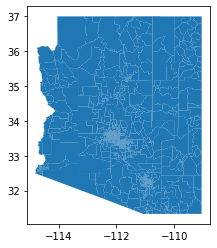

In [42]:
gdf.plot()

**Note that shapefile field names are limited to 10 characters. Check to ensure that all columns are named with fewer than 10 characters.**

In [43]:
shp_name = 'az_gen_20_prec'
create_erj_shp(gdf, shp_name)

az_gen_20_prec shapefile created.


### **Grab candidate/party info as dict for readme**

In [44]:
df['candidate_name_and_party'] = df['choice'] + ' (' + df['party'] + '), ' + df['contest']
df_field_id_to_candidate_info_dict = pd.Series(df['candidate_name_and_party'].values, index = df['field_id']).to_dict()

prop_info_dict = {'G20PRO207N': 'No vote on Proposition 207',
 'G20PRO207Y': 'Yes vote on Proposition 207',
 'G20PRO208N': 'No vote on Proposition 208',
 'G20PRO208Y': 'Yes vote on Proposition 208'}
field_id_dict = {key: prop_info_dict.get(key, df_field_id_to_candidate_info_dict[key]) for key in df_field_id_to_candidate_info_dict}

df_ssc['candidate_name_vote'] = df_ssc.contest.str.slice(start = 6, stop = -61) + ' - '+df_ssc['choice'] + ' vote on Arizona Supreme Court'
ssc_field_id_to_name_dict = pd.Series(df_ssc['candidate_name_vote'].values, index = df_ssc['field_id']).to_dict()
field_id_dict.update(ssc_field_id_to_name_dict)

location_field_desc_dict ={'PCTNUM': 'Unique number identifier for precinct from VEST file', 'PRECINCTNA':'Non-unique precinct name/identifier from VEST file', 
'UNIQUE_ID': 'Unique precinct name/identifier from SOS file', 'CDE_COUNTY': "Two character county code from VEST's file", 
'COUNTY_NAM':'Name of county', 'COUNTYFP': 'Three digit county fips code', 'CON_DIST': 'US Representative district number', 
'SLDL_DIST': 'State Legislative Lower Level district number', 'SLDU_DIST': 'State Legislative Upper Level district number',
                          'geometry':'geometry'}
field_id_dict.update(location_field_desc_dict)

field_dict_for_readme = pd.Series(gdf.columns.map(field_id_dict).values, index = list(gdf.columns)).to_dict()
field_dict_for_readme

{'UNIQUE_ID': 'Unique precinct name/identifier from SOS file',
 'COUNTYFP': 'Three digit county fips code',
 'PCTNUM': 'Unique number identifier for precinct from VEST file',
 'PRECINCTNA': 'Non-unique precinct name/identifier from VEST file',
 'CDE_COUNTY': "Two character county code from VEST's file",
 'COUNTY_NAM': 'Name of county',
 'CON_DIST': 'US Representative district number',
 'SLDL_DIST': nan,
 'SLDU_DIST': nan,
 'G20PREDBID': 'Biden, Joseph (DEM), President of the United States',
 'G20PRELJOR': 'Jorgensen, Jo (LBT), President of the United States',
 'G20PRERTRU': 'Trump, Donald J. (REP), President of the United States',
 'G20USSDKEL': 'Kelly, Mark (DEM), U.S. Senator (Term Expires Jan. 2023)',
 'G20USSRMCS': 'McSally, Martha (REP), U.S. Senator (Term Expires Jan. 2023)',
 'GCON01DOHA': "O'Halleran, Tom (DEM), U.S. Representative in Congress - District No. 1",
 'GCON01RSHE': 'Shedd, Tiffany (REP), U.S. Representative in Congress - District No. 1',
 'GCON02DKIR': 'Kirkpatrick,

## Insert readme

**Edit as applicable to state-specific processing and fields**

In [45]:
# Define varibales used in readme
fields_dict =field_dict_for_readme
stateabrv = 'AZ'
state = 'Arizona'
year = '2020'
election_type = 'general'
additional_races = 'House of Representatives, Arizona Supreme Court, SLDL, SLDU, Corporation Commissioner and Ballot Measures'
retrieval_date = '07/01/2021'
upload_date = '01/31/2022'
vest_file_link = 'https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0'
raw_data_source = "[Arizona's Secretary of State website](https://azsos.gov/2020-election-information)"
state_erj_repo = "https://github.com/nonpartisan-redistricting-datahub/erj-az"
office_codes = '''PRE - President of the United States
CON - U.S. House, accompanied by a CON_DIST column indicating district number
COC - Corporation Commissioner
USS - U.S. Senate
SSC - State Supreme Court
PRO - Proposed amendments
SU - State Legislative Upper District
SL - State Legislative Lower District
'''
additional_notes = '''Arizona does not record precinct-level election results for write-in candidates.'''

#Run and sample readme - check print to make sure as expected
print(erj_readme_template(fields_dict=fields_dict, stateabrv= stateabrv, state= state, year=year, election_type=election_type, additional_races=additional_races,retrieval_date=retrieval_date,
    upload_date=upload_date, vest_file_link=vest_file_link, raw_data_source=raw_data_source, state_erj_repo=state_erj_repo, office_codes=office_codes))

2020 AZ general election results

## RDH Date Retrieval
07/01/2021

## RDH Upload Date
01/31/2022

## Sources
The RDH retrieved the VEST 2020 general precinct boundary and election results shapefile from [VEST's Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0)
The RDH retrieved raw 2020 general election results from [Arizona's Secretary of State website](https://azsos.gov/2020-election-information)

## Notes on Field Names (adapted from VEST):
Columns reporting votes generally follow the pattern: 
One example is:
G16PREDCLI
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2 and 3 are the year of the election.*
Characters 4-6 represent the office type (see list below).
Character 7 represents the party of the candidate.
Characters 8-10 are the first three letters of the candidate's last name.

To fit within the GIS 10 character limit for field names, the naming convention is slightly 

**Export readme to erj folder if it looks good!**

In [46]:
full_readme = erj_readme_template(fields_dict=fields_dict, stateabrv= stateabrv, state= state, year=year, election_type=election_type, additional_races=additional_races,retrieval_date=retrieval_date,
    upload_date=upload_date, vest_file_link=vest_file_link, raw_data_source=raw_data_source, state_erj_repo=state_erj_repo, office_codes=office_codes)

readme_name_for_zip = './az_gen_20_prec/README.txt'
export_readme(readme_name_for_zip, state, election_type, full_readme)

readme_name_for_wp = './readme_az_gen_20_prec.txt'
export_readme(readme_name_for_wp, state, election_type, full_readme)

Arizona general  readme moved to folder
Arizona general  readme moved to folder


**Be sure to zip the shapefile with readme, upload to appropriate folder on AWS, and post updated script to Github**